# Running R from Python with rpy2

`rpy2` runs a real R session "in the back room", and moves data back and forth between the foreground Python application and the R session in various ways.

You can send text directly to the R session to be evaluated.  You can also access "wrapper" objects which pull R data into Python space, and pass data from Python into R.

## Installation

### Using R with (Ana)conda

Setting up Jupyter **Lab** in Windows.  Installing conda package `rpy2` **installs R in the conda environment**.

```shell
conda create -c conda-forge -n Renv rpy2 jupyterlab nodejs matplotlib pandas==0.23.4 ipympl geopandas fiona descartes
```
https://github.com/theislab/single-cell-tutorial/issues/7#issuecomment-458953080 for 0.23.4 issue, can't eval a dataframe from R

You only need the rpy2 package to access R, the rest are packages related to running Python in Jupyter labs, and handling spatial data in Python.

```shell
pip uninstall pyzmq
pip install pyzmq  # seemed necessary to get Jupyter lab working
# keep Jeff happy
```

```shell
# for inline plots, not really relevant to R, takes a while
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter labextension install jupyter-matplotlib
```

### Using existing R

Do you really need it?  See pets vs. cattle meme.

conda installs R when you install rpy2.  So install rpy2 with either
```shell
pip install rpy2
```
but this fails on Windows, or
```shell
conda install -c conda-forge rpy2 --no-deps
```

Then modify your PATH to include your R, e.g.
```shell
set PATH="C:\Program Files\R\R-3.4.3\bin\x64";%PATH%
```

but this seems to be inoperable, at least in windows:
```python
from rpy2 import robjects
```
fails, even though R runs when invoked from the command line.  Probably easier in Linux.

## Communicating with R

In [1]:
# Simply send text to R
import rpy2
from rpy2 import robjects  # doing this initializes the R session
R = robjects.r
# R("install.packages(c('ggplot2', 'spsurvey'))")
# R windows for selecting mirror and downloading progress pop up
R("library('spsurvey')")

'spsurvey','sp','tools','stats',...,'utils','datasets','methods','base'


In [2]:
# Or, if you wanted to manipulate R package installation with Python
import rpy2.robjects.packages as rpackages  # access R packages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
required = ['ggplot2', 'spsurvey']  # a Python variable (list)
for req in required:
    if not rpackages.isinstalled(req):
        print("Installing %s" % req)
        utils.install_packages(req)
    else:
        print("%s already installed" % req)
# this seems convoluted, but installs packages only if needed, so it's quick,
# and keeps everything on the Python side, without worrying about new environments.
for req in required:
    R.library(req)

ggplot2 already installed
spsurvey already installed


**Note:** `R...install.packages...` but `utils.install_packages` - `_` not `.` in Python.

In [3]:
# setup automatic pandas <-> R dataframe conversions
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [4]:
import numpy as np
import os
R.setwd("u:/repo/PyR")
os.chdir("u:/repo/PyR")

## Simple operations

Execute text directly in R session

In [5]:
R("2 + 2")

array([4.])

Python array sum

In [6]:
a = np.array((1, 2, 3))
a.sum()

6

Pass into R with automatic conversion, but no conversion on the way out

In [7]:
R.sum(a)

6


Copy data into R session first, then compute in R session, with automatic conversion of result

In [8]:
R.assign('a', a)
R("sum(a)")

array([6], dtype=int32)

Get a variable created in the R session

In [9]:
R("b = cbind(a, a)")
bee = R['b']
bee

array([[1, 1],
       [2, 2],
       [3, 3]], dtype=int32)

## Exchanging data frames

In [10]:
R.library('datasets')
R.data('iris')
type(R.iris)  # automatically converted to pandas dataframe

C:\Users\TBrown02\local\mc2\envs\Renv\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


pandas.core.frame.DataFrame

In [11]:
R.iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [12]:
R.iris['color'] = 'red'
R.iris.columns

Index(['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width',
       'Species'],
      dtype='object')

Why didn't the `color` column stick?  `R.iris` returns a **copy** of the dataframe in the R session.  This is common for function calls (`foo.bar()`), but surprising for attribute access (`foo.bar`), although not too unusual, see Python propterties for example.  So keep a reference to the copy, and manipulate that directly:

In [13]:
iris = R.iris
iris['color'] = 'red'
iris.columns

Index(['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width', 'Species',
       'color'],
      dtype='object')

In [14]:
from rpy2.robjects.packages import importr
grdevices = importr('grDevices')

iris.loc[iris.Species == 'setosa', 'color'] = 'blue'
R.head(iris)
iris.head()

iris['color'] = R.c(iris['color']).factor()
grdevices.png(file="test2.png", width=512, height=512)
if False:
    R.plot(iris)  # works sometimes, crashes sometimes
else:
    R.assign('iris2', iris)
    R("plot(iris2)")
grdevices.dev_off()


1


## A real application

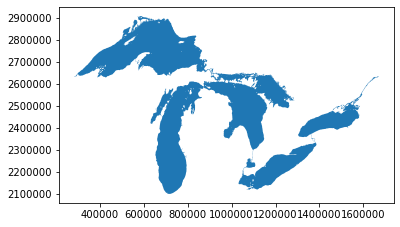

In [15]:
%matplotlib inline
import geopandas
import matplotlib.pyplot as plt

lakes = geopandas.read_file("Shapes/Great_Lakes_5.shp")
lakes.plot()

In [16]:
lakes.head()

,AREA,PERIMETER,LAKES_,LAKES_ID,LWCODE,PNAME,OWNER,geometry
0,8.195600e+10,4221007.00,2,1,W,Lake Superior,INT,"POLYGON ((582256.5 2910146, 590825.125 2910682..."
1,6.108000e+10,5363051.00,143,142,W,Lake Huron,INT,"POLYGON ((912828.125 2671729.5, 912875.875 267..."
2,1.977400e+10,2217749.00,245,244,W,Lake Ontario,INT,"POLYGON ((1642405.25 2627424, 1642288.25 26270..."
3,5.740200e+10,2590905.00,327,326,W,Lake Michigan,INT,"POLYGON ((785510.25 2595350.5, 785704.625 2595..."
4,2.570300e+10,1504214.75,461,460,W,Lake Erie,INT,"POLYGON ((1379975.75 2336141, 1380315.75 23364..."


### spsurvey: Spatial Survey Design and Analysis

"These functions provide procedures for selecting sites for spatial surveys using spatially balanced algorithms applied to discrete points, linear networks, or polygons. The probability survey designs available include independent random samples, stratified random samples, and unequal probability random samples (categorical or probability proportional to size)."

Original R code
```R
# Create the design list
Stratdsgn <- list(
  "Lake Superior"=list(panel=c(PanelOne=50), seltype="Equal", over=20),
  "Lake Michigan"=list(panel=c(PanelOne=30), seltype="Equal", over=15),
  "Lake Huron"=list(panel=c(PanelOne=30), seltype="Equal", over=15),
  "Lake Erie"=list(panel=c(PanelOne=20), seltype="Equal", over=10),
  "Lake Ontario"=list(panel=c(PanelOne=20), seltype="Equal", over=10))
```

This uses R `list()`s for a collection of named attributes at two levels, but then switches to using an R vector (`c()`) for a collection of one named attribute.  Starting from scratch I would probably either put this data in a separate file (.csv) or use a `namedtuple` to make it less cluttered.  But translating directly to Python:

In [17]:
Stratdsgn = {
  'Lake Superior': {'panel': {'PanelOne': 50}, 'seltype': "Equal", 'over': 20},
  'Lake Michigan': {'panel': {'PanelOne': 30}, 'seltype': "Equal", 'over': 15},
  'Lake Huron': {'panel': {'PanelOne': 30}, 'seltype': "Equal", 'over': 15},
  'Lake Erie': {'panel': {'PanelOne': 20}, 'seltype': "Equal", 'over': 10},
  'Lake Ontario': {'panel': {'PanelOne': 20}, 'seltype': "Equal", 'over': 10},
}

We need to convert this to R objects to call the R function.  `R.list`, aka `rpy2.robjects.r['list']` is the R `list()` function, which takes a series of `keyword=value` pairs.  In Python, keywords can't be expressions, like the string expression, `"Lake Superior"`, so you could write:

In [18]:
R_Stratdsgn = R.list(
  Lake_Superior=R.list(panel=R.c(PanelOne=50), seltype="Equal", over=20),
  Lake_Michigan=R.list(panel=R.c(PanelOne=30), seltype="Equal", over=15),
  Lake_Huron=R.list(panel=R.c(PanelOne=30), seltype="Equal", over=15),
  Lake_Erie=R.list(panel=R.c(PanelOne=20), seltype="Equal", over=10),
  Lake_Ontario=R.list(panel=R.c(PanelOne=20), seltype="Equal", over=10),
)

Or you could use Python's `**<dict>` operator, which converts the `<dict>` into a series of `keyword=value` pairs.  These is a simple example of the ** operator in the last cell of this notebook, or [see Python docs.](https://docs.python.org/3/tutorial/controlflow.html#keyword-arguments)

In [19]:
R_Stratdsgn = R.list(**{
  'Lake Superior': R.list(panel=R.c(PanelOne=50), seltype="Equal", over=20),
  'Lake Michigan': R.list(panel=R.c(PanelOne=30), seltype="Equal", over=15),
  'Lake Huron': R.list(panel=R.c(PanelOne=30), seltype="Equal", over=15),
  'Lake Erie': R.list(panel=R.c(PanelOne=20), seltype="Equal", over=10),
  'Lake Ontario': R.list(panel=R.c(PanelOne=20), seltype="Equal", over=10),
})

But if you're manipulating data in Python and only want the R version to call an R function, maybe convert the Python data structure to R objects like this:

In [20]:
R_Stratdsgn = R.list()  # top level list
for lake, setup in Stratdsgn.items():
    R_Stratdsgn = R.append(
        R_Stratdsgn, 
        R.list(**{lake: R.list(  # lists within list
            panel=R.c(**setup['panel']),  # R character vector
            seltype=setup['seltype'],
            over=setup['over'],
        )})
    )

Original R code
```R
att <- read.dbf("Great_Lakes_5")
set.seed(4447864) #This allows you to re-create the points if needed

Stratsites <- grts(
 design=Stratdsgn,       # we made this already
 DesignID="Stratified",
 type.frame="area",
 src.frame="shapefile",
 in.shape="Great_Lakes_5",
 att.frame=att,          # an R dataframe
 stratum="PNAME",
 shapefile=TRUE,         # True in Python
 prjfilename="Great_Lakes_5",
 out.shape="Stratified_Equal")
```

In [21]:
R("set.seed(4447864)")  # This allows you to re-create the points if needed
# OR
base = rpackages.importr('base')
base.set_seed(4447864)
# OR
R("set.seed(%s)" % 4447864)  # generate text and pass it to R
# OR
R['set.seed'](4447864)

rpy2.rinterface.NULL

### Calling the R `grts()` function

In [22]:
# using **dict again to allow '.' in keywords
Stratsites = R['grts'](**{
    'design': R_Stratdsgn,
    'DesignID': "Stratified",
    'type.frame': "area",
    'src.frame': "shapefile",
    'in.shape': "Shapes\\Great_Lakes_5",
    'att.frame': lakes.drop(columns='geometry'),
    # passing in a (geo)pandas dataframe, because of auto-conversion above
    'stratum': "PNAME",
    'shapefile': True,
    'prjfilename': "Shapes\\Great_Lakes_5",
    'out.shape': "Stratified_Equal",
})

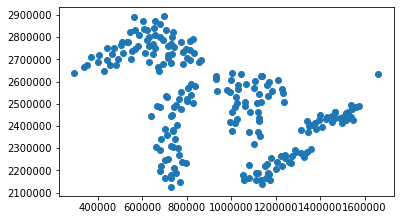

In [23]:
pts = geopandas.read_file("Stratified_Equal.shp")
pts.plot()

In [24]:
pts.head()

,siteID,xcoord,ycoord,mdcaty,wgt,stratum,panel,EvalStatus,EvalReason,AREA,PERIMETER,LAKES_,LAKES_ID,LWCODE,OWNER,geometry
0,Stratified-001,582346.742633,2.808997e+06,Equal,1.639113e+09,Lake Superior,PanelOne,NotEval,None,8.195600e+10,4221007.0,2,1,W,INT,POINT (582346.7426328704 2808997.049720222)
1,Stratified-002,532264.151645,2.776302e+06,Equal,1.639113e+09,Lake Superior,PanelOne,NotEval,None,8.195600e+10,4221007.0,2,1,W,INT,POINT (532264.1516450299 2776301.802712739)
2,Stratified-003,694205.652545,2.788025e+06,Equal,1.639113e+09,Lake Superior,PanelOne,NotEval,None,8.195600e+10,4221007.0,2,1,W,INT,POINT (694205.6525449099 2788024.692846031)
3,Stratified-004,854682.064390,2.687644e+06,Equal,1.639113e+09,Lake Superior,PanelOne,NotEval,None,8.195600e+10,4221007.0,2,1,W,INT,POINT (854682.0643900804 2687643.766496909)
4,Stratified-005,609286.604342,2.836732e+06,Equal,1.639113e+09,Lake Superior,PanelOne,NotEval,None,8.195600e+10,4221007.0,2,1,W,INT,POINT (609286.6043420924 2836732.283878186)


That was easy, but also cheating, Python just read a file R wrote.

What about the value returned by the `grts()` function?  that's a R object (class instance) specfic to the `spsurvey` package.  `rpy2` has no special knowledge of it.  Some Python introspection helps.  The remainder of this notebook is just a series of Python operations to find the structure of the `Stratsites` object.

In [25]:
Stratsites

R object with classes: ('SpatialDesign',) mapped to:
<RS4 - Python:0x0000023C14B08AC8 / R:0x0000023C072E15D8>

In [26]:
dir(Stratsites)

['_RObjectMixin__close',
 '_RObjectMixin__fifo',
 '_RObjectMixin__file',
 '_RObjectMixin__rclass',
 '_RObjectMixin__rclass_set',
 '_RObjectMixin__readlines',
 '_RObjectMixin__show',
 '_RObjectMixin__sink',
 '_RObjectMixin__slots',
 '_RObjectMixin__tempfile',
 '_RObjectMixin__unlink',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rname__',
 '__setattr__',
 '__setstate__',
 '__sexp__',
 '__sexp_refcount__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_rclass_get',
 '_rclass_set',
 'do_slot',
 'do_slot_assign',
 'isclass',
 'list_attrs',
 'named',
 'r_repr',
 'rclass',
 'rid',
 'rsame',
 'slotnames',
 'slots',
 'typeof',
 'validobject']

In [27]:
Stratsites.slots

In [28]:
dir(Stratsites.slots)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_robj',
 'items',
 'keys',
 'values']

In [29]:
Stratsites.slots.keys

<bound method RSlots.keys of <rpy2.robjects.robject.RSlots object at 0x0000023C14E7BAC8>>

In [30]:
Stratsites.slots.keys()

<generator object RSlots.keys at 0x0000023C0EA307C8>

In [31]:
list(Stratsites.slots.keys())

['design', 'data', 'coords.nrs', 'coords', 'bbox', 'proj4string', 'class']

In [32]:
list(Stratsites.slotnames())

['design', 'data', 'coords.nrs', 'coords', 'bbox', 'proj4string']

In [33]:
list(Stratsites.slots.items())

[('design', R object with classes: ('list',) mapped to:
  <ListVector - Python:0x0000023C14B6CEC8 / R:0x0000023C06F4D488>
  [ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
  R object with classes: ('list',) mapped to:
  <ListVector - Python:0x0000023C14B6CEC8 / R:0x0000023C06F4D488>
  [ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
  R object with classes: ('list',) mapped to:
  <ListVector - Python:0x0000023C14B6CEC8 / R:0x0000023C06F4D488>
  [ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
  R object with classes: ('list',) mapped to:
  <ListVector - Python:0x0000023C14B6CEC8 / R:0x0000023C06F4D488>
  [ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
  R object with classes: ('list',) mapped to:
  <ListVector - Python:0x0000023C14B6CEC8 / R:0x0000023C06F4D488>
  [ListVec..., ListVec..., ListVec..., ListVec..., ListVec...]
  R object with classes: ('list',) mapped to:
  <ListVector - Python:0x0000023C14B6CEC8 / R:0x0000023C06F4D488>
  [

In [34]:
list(Stratsites.list_attrs())

['design', 'data', 'coords.nrs', 'coords', 'bbox', 'proj4string', 'class']

In [35]:
Stratsites.do_slot('coords')

582346.742633,532264.151645,694205.652545,854682.064390,...,2439121.306802,2421024.387198,2404258.037918,2373327.731612


In [36]:
d = dict(Stratsites.slots.items())

In [37]:
list(d)

['design', 'data', 'coords.nrs', 'coords', 'bbox', 'proj4string', 'class']

In [38]:
d['design']

Lake Superior
panel
50.000000
seltype
'Equal'
over
20
Lake Michigan
panel
30.000000
seltype


In [39]:
d['data']

siteID,xcoord,ycoord,...,LAKES_ID,LWCODE,OWNER
'Stratifi...,582346.742633,2808997.049720,...,1,'W','INT'
'Stratifi...,532264.151645,2776301.802713,...,1,'W','INT'
'Stratifi...,694205.652545,2788024.692846,...,1,'W','INT'
'Stratifi...,854682.064390,2687643.766497,...,1,'W','INT'
...,...,...,...,...,...,...
'Stratifi...,1429715.352478,2439121.306802,...,244,'W','INT'
'Stratifi...,1341406.423904,2421024.387198,...,244,'W','INT'
'Stratifi...,1361035.550471,2404258.037918,...,244,'W','INT'
'Stratifi...,1344591.072282,2373327.731612,...,244,'W','INT'


To copy the modified iris dataframe into the R session you can use `R.assign('iris2', iris)`.

In [40]:
# just an example of the **<dict> operator
def x(**kwargs):
    print("Args:")
    for k, v in kwargs.items():
        print(k, v)

x(a=2, b=3)
x(c=1, **{'a': 2, "Bee's": 3})

Args:
a 2
b 3
Args:
c 1
a 2
Bee's 3
